参考资料：https://blog.csdn.net/u013733326/article/details/80250818

# Keras 入门 - 笑脸识别

本次我们将：
- 学习到一个高级的神经网络的框架，能够运行在包括TensorFlow和CNTK的几个较低级别的框架之上的框架
- 看看如何在几个小时内建立一个深入的学习算法

为什么我们要使用Keras框架呢？Keras是为了使深度学习工程师能够很快地建立和实验不同的模型的框架，正如TensorFlow是一个比Python更高级的框架，Keras是一个更高层次的框架，并提供了额外的抽象方法。最关键的是Keras能够以最短的时间让想法变为现实。然而，Keras比底层框架更具有限制性，所以有一些非常复杂的模型可以在TensorFlow中实现，但在Keras中却没有（没有更多困难）。 话虽如此，Keras对许多常见模型都能正常运行

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import kt_utils 

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

注意：正如你所看到的，我们已经从Keras中导入了很多功能， 只需直接调用它们即可轻松使用它们。 比如：X = Input(…) 或者X = ZeroPadding2D(…).

## 1 - 任务描述

下一次放假的时候，你决定和你的五个朋友一起度过一个星期。这是一个非常好的房子，在附近有很多事情要做，但最重要的好处是每个人在家里都会感到快乐，所以任何想进入房子的人都必须证明他们目前的幸福状态

作为一个深度学习的专家，为了确保“快乐才开门”规则得到严格的应用，你将建立一个算法，它使用来自前门摄像头的图片来检查这个人是否快乐，只有在人高兴的时候，门才会打开
![](images/happy-house.jpg)
你收集了你的朋友和你自己的照片，被前门的摄像头拍了下来。数据集已经标记好了
![](images/house-members.png)

我们先来加载数据集

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = kt_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


数据集的细节如下：
- 图像维度：（64，64，3）
- 训练集数量：600
- 测试集数量：150

## 2 - 使用Keras框架搭建模型

Keras非常适合快速制作模型，它可以在很短的时间内建立一个很优秀的模型，举个例子：

```
def model(input_shape):
	"""
	模型大纲
	"""
    #定义一个tensor的placeholder，维度为input_shape
    X_input = Input(input_shape)
    
    #使用0填充：X_input的周围填充0
    X = ZeroPadding2D((3,3))(X_input)
    
    # 对X使用 CONV -> BN -> RELU 块
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    #最大值池化层
    X = MaxPooling2D((2,2),name="max_pool")(X)
    
    #降维，矩阵转化为向量 + 全连接层
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    #创建模型，讲话创建一个模型的实体，我们可以用它来训练、测试。
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

请注意：Keras框架使用的变量名和我们以前使用的numpy和TensorFlow变量不一样。它不是在前向传播的每一步上创建新变量（比如X, Z1, A1, Z2, A2,…）以便于不同层之间的计算。在Keras中，我们使用X覆盖了所有的值，没有保存每一层结果，我们只需要最新的值，唯一例外的就是`X_input`，我们将它分离出来是因为它是输入的数据，我们要在最后的创建模型那一步中用到

In [3]:
def HappyModel(input_shape):
    """
    实现一个检测笑容的模型
    
    参数：
        input_shape - 输入的数据的维度
    返回：
        model - 创建的Keras的模型
        
    """
    
    #你可以参考和上面的大纲
    X_input = Input(input_shape)

    #使用0填充：X_input的周围填充0
    X = ZeroPadding2D((3, 3))(X_input)

    #对X使用 CONV -> BN -> RELU 块
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    #最大值池化层
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    #降维，矩阵转化为向量 + 全连接层
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    #创建模型，讲话创建一个模型的实体，我们可以用它来训练、测试。
    model = Model(inputs=X_input, outputs=X, name='HappyModel')

    return model

现在我们已经设计好了我们的模型了，要训练并测试模型我们需要这么做：
- 创建一个模型实体
- 编译模型，可以使用这个语句：`model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
- 训练模型：`model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`
- 评估模型：`model.evaluate(x = ..., y = ...)`

如果想要获取关于`model.compile(), model.fit(), model.evaluate()`的更多信息，可以参考这里http://keras-cn.readthedocs.io/en/latest/models/model/

In [4]:
#创建一个模型实体
happy_model = HappyModel(X_train.shape[1:])
#编译模型
happy_model.compile("adam","binary_crossentropy", metrics=['accuracy'])
#训练模型
#请注意，此操作会花费你大约6-10分钟。
happy_model.fit(X_train, Y_train, epochs=40, batch_size=50)
#评估模型
preds = happy_model.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print ("误差值 = " + str(preds[0]))
print ("准确度 = " + str(preds[1]))

Epoch 1/40
12/12 [==============================] - 1s 53ms/step - loss: 1.8886 - accuracy: 0.5667
Epoch 2/40
12/12 [==============================] - 1s 52ms/step - loss: 0.4087 - accuracy: 0.8233
Epoch 3/40
12/12 [==============================] - 1s 52ms/step - loss: 0.2441 - accuracy: 0.9033
Epoch 4/40
12/12 [==============================] - 1s 51ms/step - loss: 0.1615 - accuracy: 0.9350
Epoch 5/40
12/12 [==============================] - 1s 52ms/step - loss: 0.1217 - accuracy: 0.9667
Epoch 6/40
12/12 [==============================] - 1s 53ms/step - loss: 0.1075 - accuracy: 0.9717
Epoch 7/40
12/12 [==============================] - 1s 53ms/step - loss: 0.1013 - accuracy: 0.9700
Epoch 8/40
12/12 [==============================] - 1s 52ms/step - loss: 0.1150 - accuracy: 0.9617
Epoch 9/40
12/12 [==============================] - 1s 53ms/step - loss: 0.0848 - accuracy: 0.9800
Epoch 10/40
12/12 [==============================] - 1s 54ms/step - loss: 0.0708 - accuracy: 0.9833
Epoch 11/

只要准确度大于75%就算正常，如果你的准确度没有大于75%，你可以尝试改变模型：
```
X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)
```
- 你可以在每个块后面使用最大值池化层，它将会减少宽、高的维度
- 改变优化器，这里我们使用的是Adam
- 如果模型难以运行，并且遇到了内存不够的问题，那么就降低batch_size(12通常是一个很好的折中方案)
- 运行更多代，直到看到有良好效果的时候

即使你已经达到了75%的准确度，你也可以继续优化你的模型，以获得更好的结果

## 3 - 总结

至此，笑脸识别任务算是完成了！！

## 4 - 测试你的图片

因为对这些数据进行训练的模型可能或不能处理你自己的图片，测下自己的图片

1/1 [==============================] - 0s 140ms/step
[[0.]]


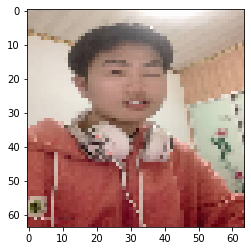

In [6]:
import tensorflow as tf

img_path = 'images/yingzi_image.jpg'

img = tf.keras.utils.load_img(img_path, target_size=(64, 64))
imshow(img)

x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happy_model.predict(x))

## 5 - 其他一些有用的功能

- model.summary()：打印出你的每一层的大小细节
- plot_model() : 绘制出布局图

In [7]:
happy_model.summary()

Model: "HappyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 70, 70, 3)        0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 64, 64, 32)        4736      
                                                                 
 bn0 (BatchNormalization)    (None, 64, 64, 32)        128       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pool (MaxPooling2D)     (None, 32, 32, 32)        0         
                                                        

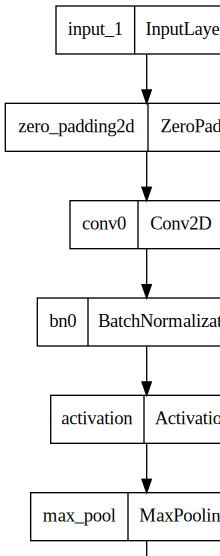

In [8]:
%matplotlib inline
plot_model(happy_model, to_file='happy_model.png')
SVG(model_to_dot(happy_model).create(prog='dot', format='svg'))

# 残差网络的搭建

这里我们将学习怎样使用残差网络构建一个非常深的卷积网络。理论上越深的网络越能够实现越复杂的功能，但是在实际上却非常难以训练。**残差网络**就是为了解决深网络的难以训练的问题的

在本文章中，我们将：
- 实现基本的残差块
- 将这些残差块放在一起，实现并训练用于图像分类的神经网络

本次实验将使用Keras框架

In [9]:
import numpy as np
import tensorflow as tf

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

import pydot
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import resnets_utils 

C:\Users\20919\anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## 1 - 神经网络的麻烦

上周，我们构建了第一个卷积神经网络。最近几年，卷积神经网络变得越来越深，从只从几层（例如AlexNet）到超过一百层

使用深层网络最大的好处就是它能够完成很复杂的功能，它能够从边缘（浅层）到非常复杂的特征（深层）中不同的抽象层次的特征中学习。然而，使用比较深的网络通常没有什么好处，一个特别大的麻烦就在于训练的时候会产生梯度消失，非常深的网络通常会有一个梯度信号，该信号会迅速的消退，从而使得梯度下降变得非常缓慢。更具体的说，在梯度下降的过程中，当你从最后一层回到第一层的时候，你在每个步骤上乘以权重矩阵，因此梯度值可以迅速的指数式地减少到0（在极少数的情况下会迅速增长，造成梯度爆炸）

在训练的过程中，你可能会看到开始几层的梯度的大小（或范数）迅速下降到0，如下图
![](images/vanishing_grad_kiank.png)
**图 1** : **梯度消失**

在前几层中随着迭代次数增加，学习的梯度下降回非常快

为了解决这个问题，我们将构建残差网络

## 2 - 构建一个残差网络

在残差网络中，一个“捷径（shortcut）”或者说“跳跃连接（skip connection）”允许梯度直接反向传播到更浅的层，如下图：
![](images/skip_connection_kiank.png)
**图 2** : 残差网络中跳跃连接的残差块示意

图像左边是神经网络的主路，图像右边是添加了一条捷径的主路，通过这些残差块堆叠在一起，可以形成一个非常深的网络

我们在视频中可以看到使用捷径的方式使得每一个残差块能够很容易学习到恒等式功能，这意味着我们可以添加很多的残差块而不会损害训练集的表现

残差块有两种类型，主要取决于输入输出的维度是否相同，下面我们来看看吧~

### 2.1 - 恒等块（Identity block）
恒等块是残差网络使用的的标准块，对应于输入的激活值（比如与$a^{[l]}$）输出激活值（比如具有相同的维度$a^{[l+1]}$）。为了具象化残差块的不同步骤，我们来看看下面的图吧~
![](images/idblock2_kiank.png)
**图 3** : **恒等块。** 使用的是跳跃连接，幅度为两层

上图中，上面的曲线路径是“捷径”，下面的直线路径是主路径。在上图中，我们依旧把CONV2D 与 ReLU包含到了每个步骤中，为了提升训练的速度，我们在每一步也把数据进行了归一化（BatchNorm），不要害怕这些东西，因为Keras框架已经实现了这些东西，调用BatchNorm只需要一行代码。

在实践中，我们要做一个更强大的版本：跳跃连接会跳过3个隐藏层而不是两个，就像下图：
![](images/idblock3_kiank.png)
**图 4** : **恒等块。** 使用的是跳跃连接，幅度为三层

![](images/Identity_block.png)

接下来我们就要实现残差网络的恒等块了，请务必查看下面的中文手册：
- 实现Conv2D：https://keras-cn.readthedocs.io/en/latest/layers/convolutional_layer/#conv2d
- 实现BatchNorm：https://keras-cn.readthedocs.io/en/latest/layers/normalization_layer/
- 实现激活：使用Activation('relu')(X)
- 添加快捷方式传递的值：https://keras-cn.readthedocs.io/en/latest/layers/merge/#add

In [10]:
def identity_block(X, f, filters, stage, block):
    """
    实现图3的恒等块
    
    参数：
        X - 输入的tensor类型的数据，维度为( m, n_H_prev, n_W_prev, n_H_prev )
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        
    返回：
        X - 恒等块的输出，tensor类型，维度为(n_H, n_W, n_C)
    
    """
    
    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    #获取过滤器
    F1, F2, F3 = filters
    
    #保存输入数据，将会用于为主路径添加捷径
    X_shortcut = X
    
    #主路径的第一部分
    ##卷积层
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1) ,padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    #主路径的第二部分
    ##卷积层
    X = Conv2D(filters=F2, kernel_size=(f,f),strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    
    #主路径的第三部分
    ##卷积层
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    ##归一化
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    ##没有ReLU激活函数
    
    #最后一步：
    ##将捷径与输入加在一起
    X = Add()([X,X_shortcut])
    ##使用ReLU激活函数
    X = Activation("relu")(X)
    
    return X

In [16]:
%reload_ext autoreload
%autoreload 2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.python.framework import ops
ops.reset_default_graph()

tf.reset_default_graph()
with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float",[3,4,4,6])
    X = np.random.randn(3,4,4,6)
    A = identity_block(A_prev,f=2,filters=[2,4,6],stage=1,block="a")
    
    test.run(tf.global_variables_initializer())
    out = test.run([A],feed_dict={A_prev:X,K.learning_phase():0})
    print("out = " + str(out[0][1][1][0]))
    
    test.close()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.
out = [0.94822973 0.         1.1610146  2.7478588  0.         1.3667699 ]


### 2.2 - 卷积块

我们已经实现了残差网络的恒等块，现在，残差网络的卷积块是另一种类型的残差块，它适用于输入输出的维度不一致的情况，它不同于上面的恒等块，与之区别在于，捷径中有一个CONV2D层，如下图：
![](images/convblock_kiank.png)
**图 5** : **卷积块**

捷径中的卷积层将把输入x xx卷积为不同的维度，因此在主路径最后那里需要适配捷径中的维度。比如：把激活值中的宽高减少2倍，我们可以使用1x1的卷积，步伐为2。捷径上的卷积层不使用任何非线性激活函数，它的主要作用是仅仅应用（学习后的）线性函数来减少输入的维度，以便在后面的加法步骤中的维度相匹配

![](images/CNN_block.png)

我们要做的是实现卷积块，请务必查看以下的中文手册：
- 实现Conv2D：https://keras-cn.readthedocs.io/en/latest/layers/convolutional_layer/#conv2d
- 实现BatchNorm：https://keras-cn.readthedocs.io/en/latest/layers/normalization_layer/
- 实现激活：使用Activation('relu')(X)
- 添加快捷方式传递的值：https://keras-cn.readthedocs.io/en/latest/layers/merge/#add

In [17]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    实现图5的卷积块
    
    参数：
        X - 输入的tensor类型的变量，维度为( m, n_H_prev, n_W_prev, n_C_prev)
        f - 整数，指定主路径中间的CONV窗口的维度
        filters - 整数列表，定义了主路径每层的卷积层的过滤器数量
        stage - 整数，根据每层的位置来命名每一层，与block参数一起使用。
        block - 字符串，据每层的位置来命名每一层，与stage参数一起使用。
        s - 整数，指定要使用的步幅
    
    返回：
        X - 卷积块的输出，tensor类型，维度为(n_H, n_W, n_C)
    """
    
    #定义命名规则
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    #获取过滤器数量
    F1, F2, F3 = filters
    
    #保存输入数据
    X_shortcut = X
    
    #主路径
    ##主路径第一部分
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)
    
    ##主路径第二部分
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)
    
    ##主路径第三部分
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    
    #捷径
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding="valid",
               name=conv_name_base+"1", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_name_base+"1")(X_shortcut)
    
    #最后一步
    X = Add()([X,X_shortcut])
    X = Activation("relu")(X)
    
    return X

In [18]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float",[3,4,4,6])
    X = np.random.randn(3,4,4,6)
    
    A = convolutional_block(A_prev,f=2,filters=[2,4,6],stage=1,block="a")
    test.run(tf.global_variables_initializer())
    
    out = test.run([A],feed_dict={A_prev:X,K.learning_phase():0})
    print("out = " + str(out[0][1][1][0]))
    
    test.close()

out = [0.09018458 1.2348975  0.46822008 0.03671761 0.         0.65516603]


## 3 - 构建你的第一个残差网络（50层）

我们已经做完所需要的所有残差块了，下面这个图就描述了神经网络的算法细节，图中的"ID BLOCK"是指标准的恒等块，"ID BLOCK X3"是指把三个恒等块放在一起
![](images/resnet_kiank.png)
![](images/Res_CNN.png)

为了实现这50层的残差网络，我们需要查看一下手册：
- 均值池化层：https://keras-cn.readthedocs.io/en/latest/layers/pooling_layer/#averagepooling2d
- Conv2D：https://keras-cn.readthedocs.io/en/latest/layers/convolutional_layer/#conv2d
- BatchNorm：https://keras-cn.readthedocs.io/en/latest/layers/normalization_layer/
- 0填充：https://keras-cn.readthedocs.io/en/latest/layers/convolutional_layer/#zeropadding2d
- 最大值池化层：https://keras-cn.readthedocs.io/en/latest/layers/pooling_layer/#maxpooling2d
- 全连接层：https://keras-cn.readthedocs.io/en/latest/layers/core_layer/#dense
- 添加快捷方式传递的值：https://keras-cn.readthedocs.io/en/latest/layers/merge/#add

In [19]:
def ResNet50(input_shape=(64,64,3),classes=6):
    """
    实现ResNet50
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    
    参数：
        input_shape - 图像数据集的维度
        classes - 整数，分类数
        
    返回：
        model - Keras框架的模型
        
    """
    
    #定义tensor类型的输入数据
    X_input = Input(input_shape)
    
    #0填充
    X = ZeroPadding2D((3,3))(X_input)
    
    #stage1
    X = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), name="conv1",
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(3,3), strides=(2,2))(X)
    
    #stage2
    X = convolutional_block(X, f=3, filters=[64,64,256], stage=2, block="a", s=1)
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="b")
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="c")
    
    #stage3
    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block="a", s=2)
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="b")
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="c")
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="d")
    
    #stage4
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block="a", s=2)
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="b")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="c")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="d")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="e")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="f")
    
    #stage5
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block="a", s=2)
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="b")
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="c")
    
    #均值池化层
    X = AveragePooling2D(pool_size=(2,2),padding="same")(X)
    
    #输出层
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name="fc"+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    
    #创建模型
    model = Model(inputs=X_input, outputs=X, name="ResNet50")
    
    return model

In [20]:
model = ResNet50(input_shape=(64,64,3),classes=6)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

现在模型已经准备好了，接下来就是加载训练集进行训练
![](images/signs_data_kiank.png)

In [21]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = resnets_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = resnets_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = resnets_utils.convert_to_one_hot(Y_test_orig, 6).T

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


运行模型两代，batch=32，每代大约20s左右

In [22]:
model.fit(X_train,Y_train,epochs=2,batch_size=32)

Train on 1080 samples
Epoch 1/2
1080/1080 [==============================] - 20s 19ms/sample - loss: 2.4117 - acc: 0.4139
Epoch 2/2
1080/1080 [==============================] - 20s 18ms/sample - loss: 0.9332 - acc: 0.6880


- 在1/2 Epoch中，loss：1-5之间算正常，acc：0.2-0.5之间算正常，尽管你的结果可能和我不一样
- 在2/2 Epoch中，loss：1-5之间算正常，acc：0.2-0.5之间算正常，你可以看到损失在下降，准确率在上升

In [23]:
preds = model.evaluate(X_test,Y_test)

print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

C:\Users\20919\anaconda3\lib\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


误差值 = 3.009190495808919
准确率 = 0.16666667


在完成这个任务之后，如果愿意的话，您还可以选择继续训练RESNET。当我们训练20代时，我们得到了更好的性能，但是在得在CPU上训练需要一个多小时。使用GPU的话，博主已经在手势数据集上训练了自己的RESNET50模型的权重，你可以使用下面的代码载并运行博主的训练模型，加载模型可能需要1min

In [24]:
#加载模型
model = load_model("ResNet50.h5") 

In [25]:
preds = model.evaluate(X_test,Y_test)
print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

误差值 = 0.10854303985834121
准确率 = 0.96666664


## 4 - 使用自己的图片测试

按理来说，训练数据集与自己的数据集是不一样的，但是我们也可以来试试嘛

my_image.shape = (1, 64, 64, 3)
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[1. 0. 0. 0. 0. 0.]]


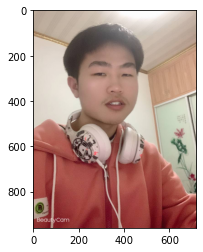

In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt # plt 用于显示图片
import imageio

%matplotlib inline

img_path = 'images/yingzi_image.jpg'

my_image = tf.keras.utils.load_img(img_path, target_size=(64, 64))
my_image = tf.keras.utils.img_to_array(my_image)

my_image = np.expand_dims(my_image,axis=0)
my_image = preprocess_input(my_image)

print("my_image.shape = " + str(my_image.shape))

print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(my_image))

my_image = imageio.imread(img_path)
plt.imshow(my_image)

In [31]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_1[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1[0][0]']           

 res2c_branch2c (Conv2D)        (None, 15, 15, 256)  16640       ['activation_9[0][0]']           
                                                                                                  
 bn2c_branch2c (BatchNormalizat  (None, 15, 15, 256)  1024       ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_3 (Add)                    (None, 15, 15, 256)  0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_7[0][0]']           
                                                                                                  
 activation_10 (Activation)     (None, 15, 15, 256)  0           ['add_3[0][0]']                  
                                                                                                  
 res3a_bra

                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_19 (Activation)     (None, 8, 8, 512)    0           ['add_6[0][0]']                  
                                                                                                  
 res3d_branch2a (Conv2D)        (None, 8, 8, 128)    65664       ['activation_19[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 8, 8, 128)   512         ['res3d_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_20 (Activation)     (None, 8, 8, 128)    0           ['bn3d_branch2a[0][0]']          
          

 bn4c_branch2a (BatchNormalizat  (None, 4, 4, 256)   1024        ['res4c_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_29 (Activation)     (None, 4, 4, 256)    0           ['bn4c_branch2a[0][0]']          
                                                                                                  
 res4c_branch2b (Conv2D)        (None, 4, 4, 256)    590080      ['activation_29[0][0]']          
                                                                                                  
 bn4c_branch2b (BatchNormalizat  (None, 4, 4, 256)   1024        ['res4c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activatio

                                                                                                  
 res4f_branch2c (Conv2D)        (None, 4, 4, 1024)   263168      ['activation_39[0][0]']          
                                                                                                  
 bn4f_branch2c (BatchNormalizat  (None, 4, 4, 1024)  4096        ['res4f_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_13 (Add)                   (None, 4, 4, 1024)   0           ['bn4f_branch2c[0][0]',          
                                                                  'activation_37[0][0]']          
                                                                                                  
 activation_40 (Activation)     (None, 4, 4, 1024)   0           ['add_13[0][0]']                 
          

 add_16 (Add)                   (None, 2, 2, 2048)   0           ['bn5c_branch2c[0][0]',          
                                                                  'activation_46[0][0]']          
                                                                                                  
 activation_49 (Activation)     (None, 2, 2, 2048)   0           ['add_16[0][0]']                 
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 1, 1, 2048)  0           ['activation_49[0][0]']          
 oling2D)                                                                                         
                                                                                                  
 flatten_1 (Flatten)            (None, 2048)         0           ['average_pooling2d_1[0][0]']    
                                                                                                  
 fc6 (Dens

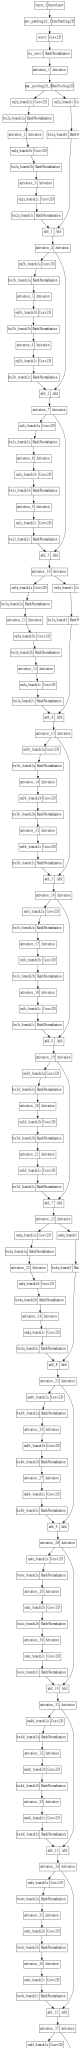

In [32]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))